In [1]:
# Load Data Cube Configuration
import sys
import datacube
import datacube.utils.rio
from datacube.utils.cog import write_cog

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import xarray as xr


# Enable importing of utilities.
import sys
import os

#import DE Africa script
sys.path.append("../Scripts")
from deafrica_datahandling import mostcommon_crs, load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_dask import create_local_dask_cluster


from odc.algo import xr_geomedian
from odc.ui import DcViewer

#This will speed up loading data
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

In [2]:
#introduce yourself and state your purpose
dc = datacube.Datacube(app="Urban_Agriculture")

In [3]:
#create_local_dask_cluster()

In [4]:
#whats available?
products = dc.list_products()

display_columns = ["name",
                   "description",
                   "platform",
                   "instrument",
                   "crs",
                   "resolution"]

products[display_columns].sort_index()

,name,description,platform,instrument,crs,resolution
id,,,,,,
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,LANDSAT_8,OLI_TIRS,NaN,NaN
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,LANDSAT_7,ETM,NaN,NaN
3,ls5_usgs_sr_scene,Landsat 5 USGS Collection 1 Level2 Surface Ref...,LANDSAT_5,TM,NaN,NaN
5,ls_usgs_wofs_scene,Historic Flood Mapping Water Observations from...,None,None,NaN,NaN
6,ls_usgs_fc_scene,Landsat Fractional Cover based on USGS Level 2...,None,None,NaN,NaN
11,ls_usgs_wofs_summary,Water Observations from Space Annual Statistics,None,None,ESRI:102022,"(-30, 30)"
12,srtm,1 second elevation model,SRTM,SIR,EPSG:4326,"(-0.00027777777778, 0.00027777777778)"
13,ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics,None,None,EPSG:6933,"(-30, 30)"
14,alos_palsar_mosaic,ALOS/PALSAR and ALOS-2/PALSAR-2 annual mosaic ...,ALOS/ALOS-2,PALSAR/PALSAR-2,EPSG:4326,"(-0.000222222222222, 0.000222222222222)"


In [ ]:
#have a look at Sentinel-2B
product = ['s2_l2a']

measurements = dc.list_measurements()
measurements.loc[product]

In [5]:
# Set the central latitude and longitude - Cape Town - Philippi Horticultural Area
central_lat = 18.56
central_lon = -34.04

# Set the buffer to load around the central coordinates
buffer = 0.05

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

In [6]:
display_map(x=study_area_lat, y=study_area_lon)

In [15]:
query = {
    'time': ('2017-01', '2017-12'),
    'x': study_area_lat,
    'y': study_area_lon,
    'output_crs': 'epsg:32734',
    'resolution':(-10,10),
}

In [16]:
#load data

bands = ['blue', 'green', 'red', 'nir', 'swir_1']

ds = dc.load(product='s2_l2a',
             measurements=bands,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 53, x: 951, y: 1132)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T08:45:43 ... 2017-12-27T08:...
  * y            (y) float64 6.236e+06 6.236e+06 ... 6.225e+06 6.225e+06
  * x            (x) float64 2.7e+05 2.7e+05 2.7e+05 ... 2.795e+05 2.795e+05
    spatial_ref  int32 32734
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    swir_1       (time, y, x) uint16 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
Attributes:
    crs:           epsg:32734
    grid_mapping:  spatial_ref


In [17]:
#how many images are there?
print('There is/are:', len(ds.time), 'image/s available')

There is/are: 53 image/s available


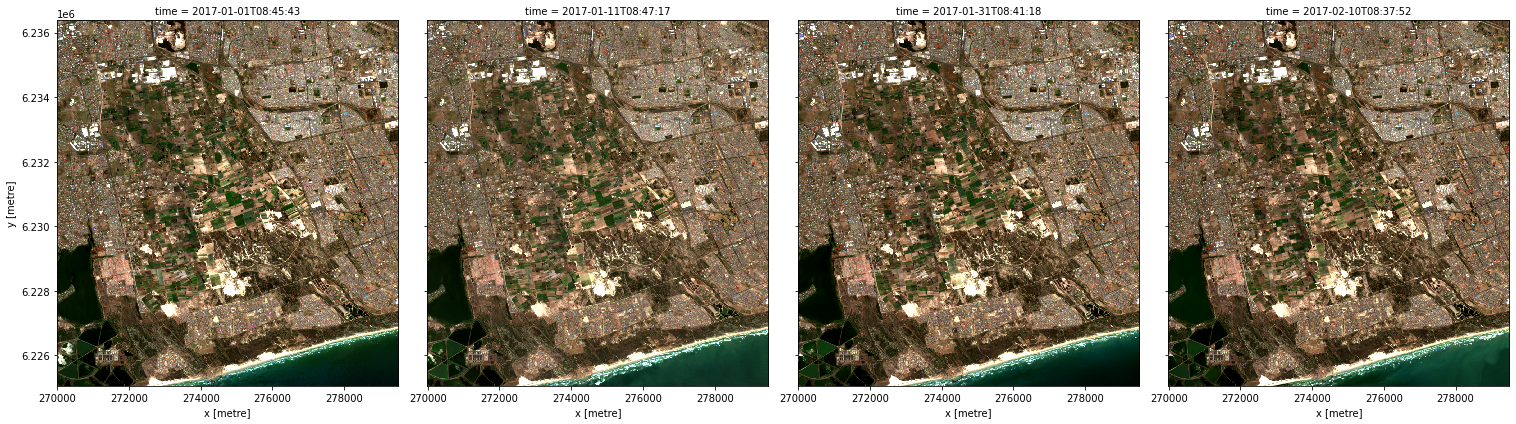

In [18]:
#show the first 4
rgb(ds, index=[0,1,2,3])

In [19]:
#load analysis ready with min_gooddata

ds = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              dask_chunks={},
              group_by='solar_day',
              min_gooddata=0.75,
              **query)
#print(ds)

../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 34 out of 52 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Returning 34 time steps as a dask array


In [20]:
#how many images are there?
print('Now there is/are:', len(ds.time), 'image/s available')

Now there is/are: 34 image/s available


In [21]:
#resample 3 months @ the start of the month = 4 images per year
resample_ds = ds.resample(time='3MS')

#calculate geomedian for every resampled image
geomedian_resample = resample_ds.map(xr_geomedian)

#how does it differ from the original
geomedian_resample

<xarray.Dataset>
Dimensions:  (time: 4, x: 951, y: 1132)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-04-01 2017-07-01 2017-10-01
  * x        (x) float64 2.7e+05 2.7e+05 2.7e+05 ... 2.795e+05 2.795e+05
  * y        (y) float64 6.236e+06 6.236e+06 6.236e+06 ... 6.225e+06 6.225e+06
Data variables:
    blue     (time, y, x) float32 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    green    (time, y, x) float32 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    red      (time, y, x) float32 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    nir      (time, y, x) float32 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>
    swir_1   (time, y, x) float32 dask.array<chunksize=(1, 1132, 951), meta=np.ndarray>

In [22]:
#show the 4 resampled images
rgb(geomedian_resample, bands=['red', 'green', 'blue'], col="time", col_wrap=4)

KeyboardInterrupt: 

In [ ]:
# Calculate EVI on the resampled images and add it to the loaded dataset
ds = calculate_indices(geomedian_resample, 'EVI', collection='s2')
ds_index = ds.EVI

In [ ]:
#plot
ds_index.plot(col='time', vmin=-0.50, vmax=0.8, cmap='RdYlGn')